In [293]:
import re
import requests
import math
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Matplotlib is building the font cache; this may take a moment.


Utility functions

In [294]:
def get_json_request(url):
  return requests.get(url).json()

def strip_html(text):
  """ remove HTML tags from a string """
  if not isinstance(text, str):
    return ""
  clean = re.compile("<.*?>")
  return re.sub(clean, "", text)

def preprocess_events(events):
  """ construct dictionary from event data """
  return [
    {
      "title": event["title"],
      "group_title": event["group_title"],
      "url": event["url"],
      "description": strip_html(event["description"]),
      "date": event["date"],
      "date_time": event["date_time"],
      "location": event["location"],
      "location_title": event["location_title"],
      "location_latitude": float(event["location_latitude"]) if event["location_latitude"] != None else 0,
      "location_longitude": float(event["location_longitude"]) if event["location_longitude"] != None else 0,
      "cost": event["cost"],
      "thumbnail": event["thumbnail"],
      "event_types": event["event_types"],
      "event_types_audience": event["event_types_audience"],
    }
    for event in events
  ]

def get_parking_lot_latlng(lot_code, basemap_parking_lot):
  for row in basemap_parking_lot.itertuples():
    if row.FAC_CODE == lot_code:
      return [row.geometry.centroid.x, row.geometry.centroid.y]
  return []


def preprocess_parkings(parking_lots, basemap_parking_lot):
  """ construct dictionary from parking lot data """
  results = []
  for parking_lot in parking_lots:
    lot_code = parking_lot["FAC_Code"]
    lot_name = parking_lot["FAC_Description"]
    lot_capacity = parking_lot["FAC_Capacity"]
    lot_occupied = parking_lot["FAC_Occupied"]
    lot_available = parking_lot["FAC_Available"]
    lot_lnglat = get_parking_lot_latlng(lot_code, basemap_parking_lot)
    
    results.append({
      "lot_name": lot_name,
      "lot_capacity": lot_capacity,
      "lot_occupied": lot_occupied,
      "lot_available": lot_available,
      "lot_location_latitude": float(lot_lnglat[1]),
      "lot_location_longitude": float(lot_lnglat[0]),
    })

  return results

# haversine function to calculate distance (in kilometers)
def haversine(lat1, lon1, lat2, lon2):
    # earth radius in kilometers
    R = 6371
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    # distance in kilometers
    return R * c

In [295]:
URL_TAMU_VISITOR_GARAGE_OCCUPANCY = "https://transport.tamu.edu/ParkingFeed/api/lots/occupancy"
URL_TAMU_EVENTS = "https://calendar.tamu.edu/live/json/events/group"
URL_TAMU_BASEMAP_PARKING_LOTS = "https://gis.tamu.edu/arcgis/rest/services/FCOR/TAMU_BaseMap/MapServer/0/query?where=1=1&outFields=*&f=geojson&&returnGeometry=true"

data_tamu_visitor_garage_occupancy = get_json_request(URL_TAMU_VISITOR_GARAGE_OCCUPANCY)
data_tamu_events = get_json_request(URL_TAMU_EVENTS)
data_tamu_basemap_parking_lot = get_json_request(URL_TAMU_BASEMAP_PARKING_LOTS)

In [318]:
preprocessed_events = preprocess_events(data_tamu_events)[:20]
preprocessed_tamu_basemap = gpd.GeoDataFrame.from_features(data_tamu_basemap_parking_lot["features"])
preprocessed_parking_lot = preprocess_parkings(data_tamu_visitor_garage_occupancy, preprocessed_tamu_basemap)

In [323]:
# intialize knowledge graph
G = nx.Graph()

# add event nodes
for event in preprocessed_events:
    G.add_node(event["title"], **event, type="event")

# add parking lot nodes
for parking_lot in preprocessed_parking_lot:
    G.add_node(parking_lot["lot_name"], lat=parking_lot["lot_location_latitude"], lon=parking_lot["lot_location_longitude"], type="parking")

# add edges attributes with distance threshold in km
distance_threshold = 1000
for event in preprocessed_events:
    for parking_lot in preprocessed_parking_lot:
        distance = haversine(
            event["location_latitude"], 
            event["location_longitude"], 
            parking_lot["lot_location_latitude"], 
            parking_lot["lot_location_longitude"]
        )
        if distance <= distance_threshold:
            G.add_edge(event["title"], parking_lot["lot_name"], relationship="is_near", distance=round(distance,2))

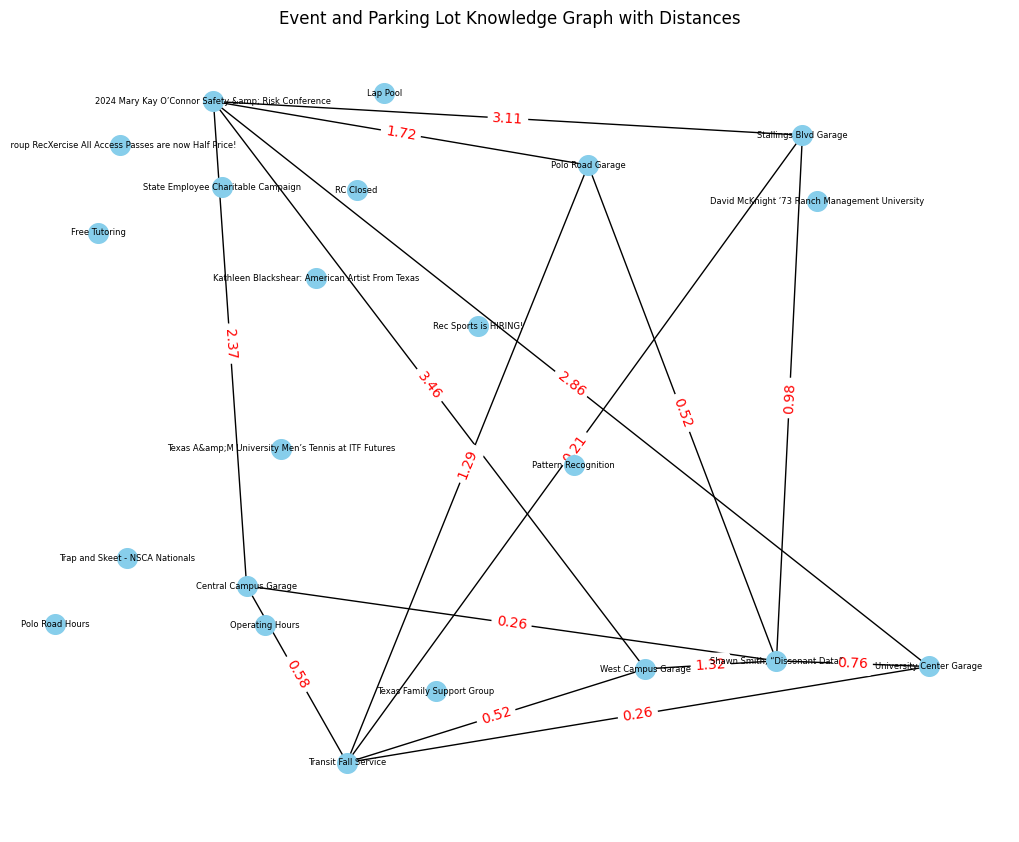

In [324]:
# intialize layout
pos = nx.random_layout(G)
# draw graph with node
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, font_size=6, font_weight='normal')
# draw edege
edge_labels = nx.get_edge_attributes(G, 'distance')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Event and Parking Lot Knowledge Graph with Distances")
plt.show()